In [25]:
%load_ext autoreload
%autoreload 2


# 1. Pre-processing

In [22]:
from pytorch_tabnet.tab_model import TabNetClassifier
import pytorch_tabnet.tab_model
import pytorch_tabnet
import pytorch_tabnet.tab_network
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline
import importlib

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())
    
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)
        
        
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

con_idxs = [i for i, f in enumerate(features) if f not in categorical_columns]

'''
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
'''
base_auc = 0.9275363726026278
base_acc = 0.8677685950413223
beat_auc = 0
beat_acc = 0

base_auc_2 = 0.9313200431309823
base_acc_2 = 0.8754208754208754
beat_auc_2 = 0
beat_acc_2 = 0

'''
EXPLAIN:
    - base_auc: roc auc score of the pretrained version of original model
    - base_auc_2: roc auc score of the TabNet modified version with no pretraining
    => Now we test the TabNet modified version with pretraining
'''

#### Customized train, valid, test
X_train = np.array(pd.read_csv('X_train.csv'))
y_train = np.array(pd.read_csv('y_train.csv')).ravel()

X_valid = np.array(pd.read_csv('X_valid.csv'))
y_valid = np.array(pd.read_csv('y_valid.csv')).ravel()

X_test = np.array(pd.read_csv('X_test.csv'))
y_test = np.array(pd.read_csv('y_test.csv')).ravel()

File already exists.
39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


# 2. Pretraining

In [23]:
'''
First, I test with the same model, with con embedding in the TabNet pretrainer, and with con embedding in TabNet classifier.
'''

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    con_idxs=con_idxs,
    con_emb_dim=35,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
)
max_epochs = 1000 if not os.getenv("CI", False) else 2

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,

) 




unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Device used : cpu
In TabNet Pretraining >> before embedder, con_idxs =  [2]
In pretraining.py, _set_network, con_idxs =  ([2],)
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
epoch 0  | loss: 4.42931 | val_0_unsup_loss: 17.27509|  0:00:02s
epoch 1  | loss: 3.42494 | val_0_unsup_loss: 3.48252 |  0:00:06s
epoch 2  | loss: 3.38478 | val_0_unsup_loss: 3.39749 |  0:00:09s
epoch 3  | loss: 3.36444 | val_0_unsup_loss: 3.38328 |  0:00:12s
epoch 4  | loss: 3.36098 | val_0_unsup_loss: 3.38132 |  0:00:15s
epoch 5  | loss: 3.35804 | val_0_unsup_loss: 3.36983 |  0:00:19s
epoch 6  | loss: 3.36765 | val_0_unsup_loss: 3.3755  |  0:00:22s
epoch 7  | loss: 3.36654 | val_0_unsup_loss: 3.37346 |  0:00:25s
epoch 8  | loss: 3.35917 | val_0_unsup_loss: 3.37332 |  0:00:29s
epoch 9  | loss: 3.36274 | val_0_unsup_loss: 3.37293 |  0:00:32s
epoch 10 | loss: 3.36025 | val_0_unsup_loss: 3.37199 |  0:00:36s

Early stopping occurred at e

In [24]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [25]:
X_valid.shape

(3221, 14)

In [26]:
reconstructed_X.shape

(3221, 48)

In [27]:
embedded_X.shape

(3221, 48)

In [28]:
embedded_X

array([[ 1.3500384e+00,  1.0216109e+00, -6.7228359e+03, ...,
        -5.9349823e-01,  1.8829045e+00,  8.7137467e-01],
       [-1.9986119e+00,  1.0216109e+00, -4.2424561e+03, ...,
        -5.9349823e-01,  1.8829045e+00,  8.7137467e-01],
       [ 1.9383644e+00,  1.0216109e+00, -2.8414488e+04, ...,
        -5.9349823e-01,  4.0455222e-01,  8.7137467e-01],
       ...,
       [ 1.5728759e+00, -1.5267214e+00, -1.7502080e+04, ...,
        -5.9349823e-01, -7.7746201e-01,  8.7137467e-01],
       [-1.9025394e-01, -3.2146974e+00, -3.7563000e+04, ...,
        -5.9349823e-01, -4.3232298e-01,  8.7137467e-01],
       [ 1.9383644e+00,  1.0216109e+00, -2.2666479e+04, ...,
        -5.9349823e-01, -4.3232298e-01,  8.7137467e-01]], dtype=float32)

In [29]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

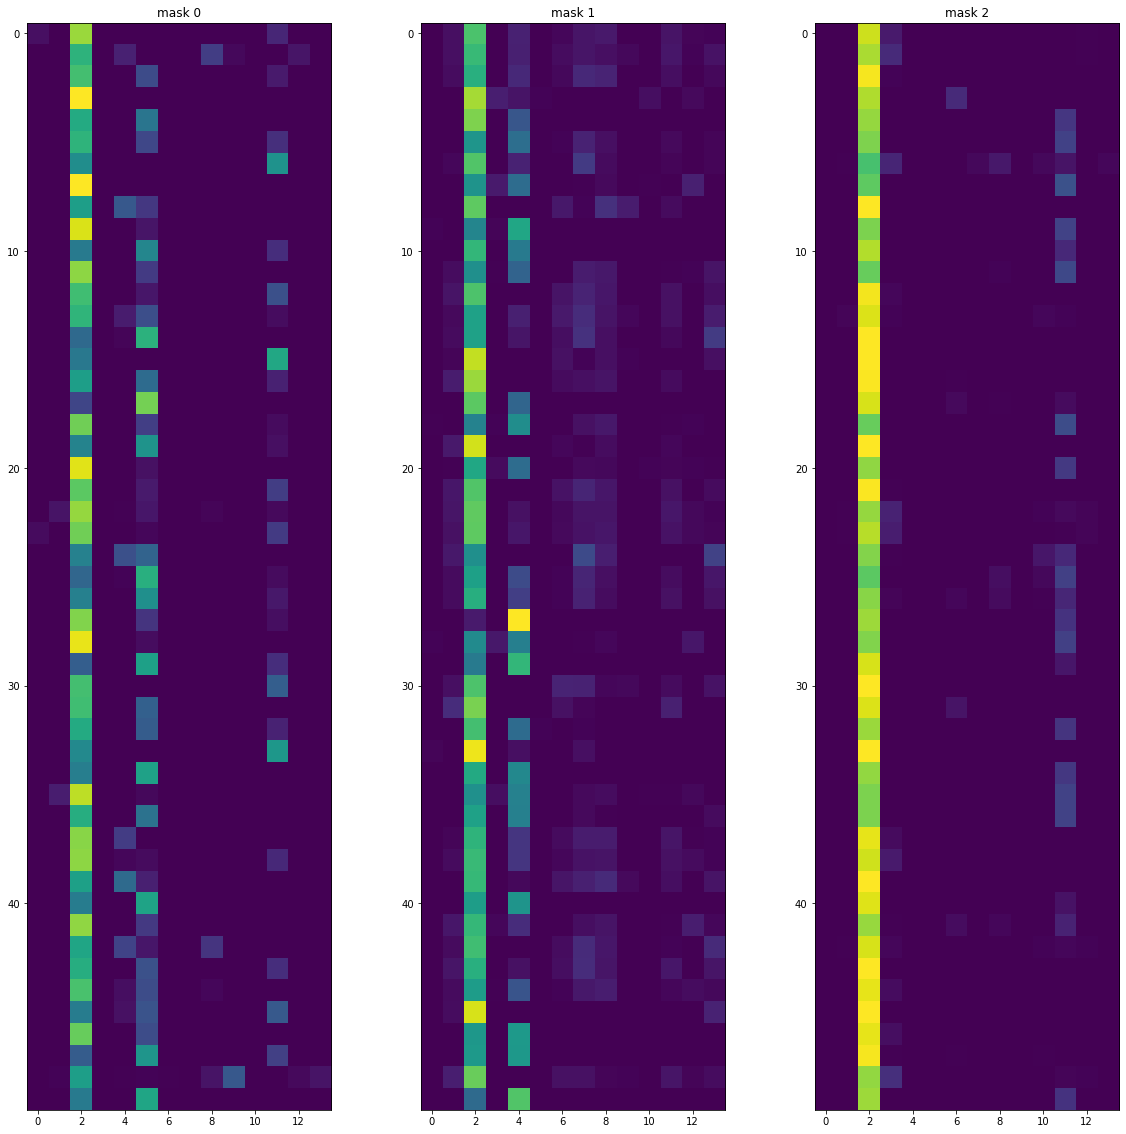

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


In [31]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip
Device used : cpu
Device used : cpu
In TabNet Pretraining >> before embedder, con_idxs =  [2]
In pretraining.py, _set_network, con_idxs =  ([2],)
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14


In [32]:
unsupervised_model.get_params()

{'cat_dims': [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42],
 'cat_emb_dim': 1,
 'cat_idxs': [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'clip_value': 1,
 'con_emb_dim': 35,
 'con_idxs': [2],
 'device_name': 'auto',
 'dropout': 1,
 'embed_dim': 512,
 'epsilon': 1e-15,
 'forward_expansion': 1,
 'gamma': 1.3,
 'heads': 1,
 'input_dim': 14,
 'lambda_sparse': 0.001,
 'mask_type': 'entmax',
 'momentum': 0.02,
 'n_a': 8,
 'n_d': 8,
 'n_indep_decoder': 1,
 'n_independent': 2,
 'n_shared': 2,
 'n_shared_decoder': 1,
 'n_steps': 3,
 'optimizer_fn': torch.optim.adam.Adam,
 'optimizer_params': {'lr': 0.02},
 'output_dim': None,
 'scheduler_fn': None,
 'scheduler_params': {},
 'seed': 0,
 'verbose': 1}

In [33]:
loaded_pretrain

TabNetPretrainer(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, con_idxs=[2], con_emb_dim=35, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=14, output_dim=None, embed_dim=512, dropout=1, forward_expansion=1, heads=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [34]:
unsupervised_model

TabNetPretrainer(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, con_idxs=[2], con_emb_dim=35, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=14, output_dim=None, embed_dim=512, dropout=1, forward_expansion=1, heads=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

# 3. Classifier

In [35]:
max_epochs = 7700 if not os.getenv("CI", False) else 2


clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        from_unsupervised=loaded_pretrain
        )


Device used : cpu
In abstract_model.py, _set_network, con_idxs =  [2]
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
Loading weights from unsupervised pretraining



D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: con_emb_dim changed from 1 to 35
  warnings.warn(wrn_msg)
D:\Intern\ASTAR\Topic 1\Script\tabnet - v2\pytorch_tabnet\abstract_model.py:109: UserWarning: Pretraining: con_idxs changed from [] to [2]
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69546 | train_auc: 0.60583 | valid_auc: 0.61842 |  0:00:04s
epoch 1  | loss: 0.58377 | train_auc: 0.77838 | valid_auc: 0.78961 |  0:00:08s
epoch 2  | loss: 0.50047 | train_auc: 0.83679 | valid_auc: 0.854   |  0:00:12s
epoch 3  | loss: 0.45362 | train_auc: 0.86865 | valid_auc: 0.88007 |  0:00:17s
epoch 4  | loss: 0.42371 | train_auc: 0.8861  | valid_auc: 0.89017 |  0:00:21s
epoch 5  | loss: 0.40672 | train_auc: 0.89792 | valid_auc: 0.89936 |  0:00:25s
epoch 6  | loss: 0.38559 | train_auc: 0.90513 | valid_auc: 0.90781 |  0:00:29s
epoch 7  | loss: 0.37616 | train_auc: 0.9089  | valid_auc: 0.90706 |  0:00:33s
epoch 8  | loss: 0.36481 | train_auc: 0.91055 | valid_auc: 0.90773 |  0:00:38s
epoch 9  | loss: 0.35733 | train_auc: 0.91738 | valid_auc: 0.9165  |  0:00:43s
epoch 10 | loss: 0.35061 | train_auc: 0.91973 | valid_auc: 0.91791 |  0:00:47s
epoch 11 | loss: 0.34506 | train_auc: 0.91677 | valid_auc: 0.91316 |  0:00:52s
epoch 12 | loss: 0.34911 | train_auc: 0.92361 | vali

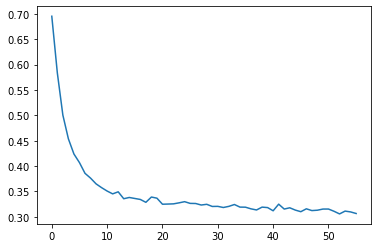

In [36]:
# plot losses
plt.plot(clf.history['loss'])

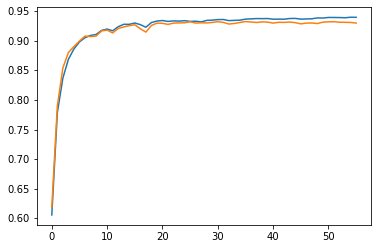

In [37]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

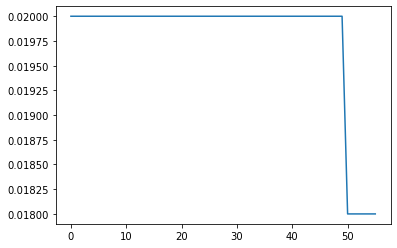

In [38]:
# plot learning rates
plt.plot(clf.history['lr'])

In [39]:
preds_class = clf.predict(X_test)
preds = clf.predict_proba(X_test)
test_acc = accuracy_score(y_test, preds_class)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print("acc:", test_acc)
print("auc:", test_auc)

acc: 0.8243036424854606
auc: 0.9311197191375846


In [40]:
clf.feature_importances_

array([0.00000000e+00, 6.17697807e-03, 2.67272908e-01, 4.45911382e-03,
       7.60578631e-02, 9.95226252e-02, 1.80366080e-03, 0.00000000e+00,
       2.52882012e-05, 7.17992487e-03, 4.54585135e-01, 4.79427741e-02,
       2.09781954e-02, 1.39955330e-02])